In [1]:
import polars as pl
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from datetime import date
from tqdm.notebook import tqdm
import itertools
import math
from pathlib import Path

## 🧩 Funciones del Proceso de Modelado

### 🛠️ Ingeniería de Features: Lags, Medias Móviles y Volatilidad

Para que el modelo pueda capturar la dinámica temporal del precio de Bitcoin, se generan variables derivadas que reflejan su comportamiento reciente. Estas transformaciones permiten que el modelo aprenda patrones de evolución, tendencia y volatilidad, más allá del valor puntual del día.

#### 🔁 Lags (`price_lag_N`)
- Representan el precio de Bitcoin en días anteriores.
- Por ejemplo, `price_lag_1` es el precio de ayer, `price_lag_3` el de hace tres días.
- Permiten al modelo tener "memoria" y detectar patrones de reversión, continuidad o momentum.

#### 📈 Medias móviles (`price_ma_N`)
- Calculan el promedio del precio en una ventana de N días.
- Suavizan el ruido diario y capturan tendencias sostenidas.
- Por ejemplo, `price_ma_7` refleja la tendencia semanal del precio.

#### 📉 Desviaciones estándar (`price_std_N`)
- Miden la volatilidad del precio en la misma ventana.
- Ayudan al modelo a identificar si el mercado está estable o agitado.
- Por ejemplo, `price_std_14` indica cuán variable ha sido el precio en las últimas dos semanas.

#### ⚠️ Eliminación de registros iniciales
- Al aplicar `shift()` y `rolling_*()`, los primeros N registros del DataFrame contienen valores nulos.
- Se eliminan automáticamente para evitar errores en etapas posteriores del pipeline.

> Estas features enriquecen el dataset con información temporal que es clave para modelos predictivos sobre series financieras. Su inclusión mejora la capacidad del modelo para anticipar movimientos futuros del precio.

In [2]:
def add_features(df: pl.DataFrame, columnas: list) -> pl.DataFrame:        
    """... (código original sin cambios) ..."""
    # Lags para features de mercado
    for column in columnas:
        if column in ['date', 'price']:
            continue
        df = df.with_columns(pl.col(column).shift(1).alias(f'{column}_lag_1'))

    # **CALCULAR _change_1d
    for column in columnas:
        if column in ['date', 'total_volume']:
            continue
        df = df.with_columns(((pl.col(column) - pl.col(column).shift(1)) / pl.col(column).shift(1)).alias(f"{column}_change_1d")  )     

    # Ratios intermercado
    for column in columnas:
        if column in ['date', 'price', 'total_volume']:
            continue
        df = df.with_columns((pl.col("price") / pl.col(column)).alias(f"btc_{column}_ratio"))

    df = df.with_columns([
        pl.when(pl.col("price_change_1d") > 0)
          .then(1)
          .when(pl.col("price_change_1d") < 0)
          .then(-1)
          .otherwise(0)
          .alias("price_direction_1d"),
    ])
    # Features temporales básicas
    df = df.with_columns([
        pl.col("date").dt.year().alias("year"),
        pl.col("date").dt.month().alias("month"),
        pl.col("date").dt.day().alias("day"),
        pl.col("date").dt.weekday().alias("weekday"),
    ])
    # Lags de precio Variados
    lags = [15, 30, 45, 60, 75, 90]
    for lag in lags:
        df = df.with_columns([
            # Cambios en lags propuestos
            pl.col("price").shift(lag).alias(f"btc_lag_{lag}"),
        ])
    # Rolling statistics de precio
    windows = [3, 7, 14, 21, 30]
    for window in windows:
        df = df.with_columns([
            pl.col("price").rolling_std(window).alias(f"btc_std_{window}"),
        ])
    windows = [30, 60, 90]
    for window in windows:
        df = df.with_columns([
            # Medias de los Instrumentos en Ciertas Ventanas
            pl.col("price").rolling_mean(window).alias(f"price_ma_{window}"),
            # Momentum adicional basado en precio (no confundir con price_change_1d)
            ((pl.col("price") / pl.col(f"btc_lag_{window}")) - 1).alias(f"btc_momentum_{window}d"),
        ])
    # **TARGET: precio de mañana (SIEMPRE AL FINAL)**
    df = df.with_columns(pl.col("price").shift(-1).alias("price_tomorrow"))
    df = df.with_columns(
        pl.when((pl.col('price_tomorrow') - pl.col('price')) > 0)
        .then(1)
        .when((pl.col('price_tomorrow') - pl.col('price')) < 0)
        .then(-1)
        .otherwise(0)
        .alias('target_direction')
    )
    # Eliminar NaNs (ÚLTIMO PASO)
    max_offset = max(max(lags, default=0), max(windows, default=0), 1)
    return (df.slice(max_offset, df.shape[0] - max_offset))

### 🧠 Vamos a dividir la Data
### 🔹 Dataset 1: **2015-01-15 → 2024-12-31**  `(df_trainval)`
- Uso: Entrenamiento, validación, ajuste de hiperparámetros, iteración para frecuente Testeo.
- Ventaja: Contiene suficiente historia (~3600 días) para capturar ciclos, eventos macro, y patrones estacionales.
- Objetivo: Afinar el modelo hasta que sus métricas internas (RMSE, MAE, precisión direccional) sean satisfactorias.

### 🔹 Dataset 2: **2025-01-01 → presente**   `(df_future)`
- Uso: Evaluación externa, simulación de predicciones reales.
- Ventaja: Nunca visto por el modelo, permite medir su capacidad de anticipar el futuro.
- Objetivo: Validar si el modelo realmente predice bien, y cuantificar sus errores en condiciones reales.

In [3]:
def temporal_split(df: pl.DataFrame, target: str, test_size: float = 0.4, fecha_corte: date = date(2024, 12, 31)) \
        -> tuple[pl.DataFrame, pl.DataFrame, np.array, np.array, np.array, np.array, pl.DataFrame, pl.DataFrame, np.array, np.array]:
    """"""
    # División
    df_trainval = df.filter(pl.col("date") <= fecha_corte)
    df_future = df.filter(pl.col("date") > fecha_corte)

    # Ordenar por fecha
    df_trainval = df_trainval.sort("date")
    df_future = df_future.sort("date")
    # Split temporal (no aleatorio)
    split_idx = int(len(df_trainval) * (1 - test_size))

    # Obtengo los DataFrames de Train y Test (dentro de df_trainval que es la única data que podrá tener contacto con el Modelo)
    df_train = df_trainval.slice(0, split_idx)
    df_test = df_trainval.slice(split_idx, len(df_trainval) - split_idx)

    # Columnas predictoras (excluimos 'date', 'price_tomorrow', 'price_direction')
    feature_cols = [col for col in df_train.columns if col not in ["date", target, 'price_tomorrow']]

    # Convertir a numpy
    X_train = df_train.select(feature_cols).to_numpy()
    y_train = df_train.select(target).to_numpy().flatten()

    X_test = df_test.select(feature_cols).to_numpy()
    y_test = df_test.select(target).to_numpy().flatten()

    X_test_future = df_future.select(feature_cols).to_numpy()
    y_test_future = df_future.select(target).to_numpy().flatten()

    return df_trainval, df_future, X_train, y_train, X_test, y_test, df_test, df_train, X_test_future, y_test_future

### 📊 Evaluación del Modelo: Dirección, Retorno y Robustez
Dado el carácter altamente volátil y especulativo del mercado de criptomonedas, predecir el precio exacto de Bitcoin resulta extremadamente complejo y poco práctico. Por ello, este modelo se enfoca exclusivamente en anticipar la dirección del movimiento diario: si el precio subirá o bajará al día siguiente.

Este enfoque permite simplificar la tarea predictiva y alinearla con estrategias operativas más realistas, como la toma de decisiones binarias (entrada em Short vs. entrada en Long). En consecuencia, métricas tradicionales como MAE o RMSE no son aplicables, ya que no se evalúa la magnitud del error, sino la capacidad de acierto direccional.

#### ✅ `directional_accuracy`
- Mide el porcentaje de veces que el modelo predice correctamente la dirección del movimiento (subida o bajada). 
- Es una métrica exacta y trazable, ya que se compara directamente con el signo del cambio real.
- Por ejemplo, si el modelo predice "sube" y efectivamente el precio sube, se considera un acierto.

#### 📈 `cumulative_return`
- Calcula el retorno acumulado de una estrategia que opera según las señales del modelo.
- Se asume una operación diaria con entrada al cierre del día actual y salida al cierre del día siguiente.
- Se descuenta un costo fijo de operación del 0.1% (0.001) por cada transacción.
- Aunque útil como referencia, no representa un retorno realista, ya que:
    - No considera el spread ni comisiones variables.
    - Asume ejecución perfecta en los cierres, lo cual es difícil en la práctica.

#### 📉 `sharpe_ratio`
- Evalúa la relación entre retorno y riesgo de la estrategia.
- Se calcula como el retorno promedio dividido por la desviación estándar de los retornos.
- Un valor alto indica que el modelo genera retornos consistentes con baja volatilidad.
- Debe interpretarse con cautela, ya que depende de precios de cierre y no refleja condiciones reales de ejecución.

#### 📆 `cagr (Tasa de Crecimiento Anual Compuesta)`
- Estima el crecimiento anualizado del capital si se siguiera la estrategia del modelo durante todo el periodo.
- Útil para comparar con benchmarks de largo plazo.
- Es una métrica de referencia, no una proyección garantizada.

#### ⚠️ Importante: 
Las métricas basadas en precios (cumulative_return, sharpe_ratio, cagr) son aproximaciones teóricas. En escenarios reales, factores como el spread, la latencia, el tipo de cliente, y las comisiones del broker afectan significativamente los resultados. Solo directional_accuracy puede considerarse una métrica exacta y operativamente trazable.

In [4]:

def evaluar_modelo(
    modelo: xgb.XGBRegressor,
    X_test: np.array,
    y_test: np.array,
    df_test: pl.DataFrame,
    transaction_cost_pct: float = 0.001  
) -> dict:
    """
    Versión de la función de evaluación que incluye costos de transacción como parámetro.
    El costo por defecto es 0.001 (0.1%).
    """
    preds = modelo.predict(X_test)
    df_test = df_test.sort('date')
    prices_hoy = df_test['price'].to_numpy()
    prices_tomorrow = df_test['price_tomorrow'].to_numpy()

    aciertos_direccion = 0
    retornos = []
    retornos_porcentuales = []
    tasas_libre_riesgos = []
    for i in range(len(preds)):
        retorno = abs(prices_tomorrow[i] - prices_hoy[i])
        tasa_libre = prices_hoy[i] * transaction_cost_pct
        tasas_libre_riesgos.append(tasa_libre)
        if (preds[i] > 0 and y_test[i] > 0) or (preds[i] < 0 and y_test[i] < 0):
            # Si entro en condicional acerto direccion
            aciertos_direccion += 1
            retornos.append(retorno)
            retornos_porcentuales.append((retorno - tasa_libre) / prices_hoy[i] )
        else:
            retornos.append(-retorno)
            retornos_porcentuales.append(-(retorno + tasa_libre) / prices_hoy[i] )

    # sharpe_ratio
    exce_retorno = np.array(retornos) - np.array(tasas_libre_riesgos)
    sharpe_ratio = np.mean(exce_retorno) / np.std(exce_retorno)        
    # directional_accuracy
    directional_accuracy = aciertos_direccion / len(preds)
    # cumalative_return
    n_evaluated_days = len(preds)
    retornos_porcentuales_np = np.array(retornos_porcentuales)
    cumulative_return = np.prod(1 + retornos_porcentuales_np) - 1
    cagr = (1 + cumulative_return)**(365 / n_evaluated_days) - 1  # CAGR anualizado

    return {
        "directional_accuracy": directional_accuracy,
        "sharpe_ratio": sharpe_ratio,
        "cumulative_return": cumulative_return,
        "Compound_Annual_Growth_Rate": cagr,
        "n_evaluated_days": n_evaluated_days,
    }

### 📈 Modelado con XGBoost `entrenamiento`, `testeo` y `prueba`

In [5]:
def entrena_evalua(estimators: int,
                   depth: int,
                   learning_rate: float,
                   subsample: float,
                   colsample: float,
                   X_train: np.array,
                   y_train: np.array,
                   X_test: np.array,
                   y_test: np.array,
                   df_test: pl.DataFrame,
                   X_test_future: np.array,
                   y_test_future: np.array,
                   df_future: np.array,
                   iteracion: int = 0,
                   return_model: bool = False) -> dict:

    tscv = TimeSeriesSplit(n_splits=5)

    param_grid = {
        "n_estimators": [estimators],
        "max_depth": [depth],
        "learning_rate": [learning_rate],
        "subsample": [subsample],
        "colsample_bytree": [colsample]
    }

    model = xgb.XGBRegressor(random_state=42)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=tscv,    # Aca el cambio
        scoring="neg_mean_absolute_error",
        verbose=0,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    modelo_final = grid_search.best_estimator_

    if return_model:
        return modelo_final
    
    metricas_test = evaluar_modelo(modelo=modelo_final, X_test=X_test, y_test=y_test, df_test=df_test)
    metricas_test_future = evaluar_modelo(modelo=modelo_final, X_test=X_test_future, y_test=y_test_future, df_test=df_future)

    metricas_and_features_test = metricas_test | {'estimators': estimators,
                                                  'depth': depth,
                                                  'learning_rate': learning_rate,
                                                  'subsample': subsample,
                                                  'colsample_bytree': colsample,
                                                  'iteracion': iteracion}
    
    metricas_and_features_real = metricas_test_future | {'estimators': estimators,
                                                         'depth': depth,
                                                         'learning_rate': learning_rate,
                                                         'subsample': subsample,
                                                         'colsample_bytree': colsample,
                                                         'iteracion': iteracion}

    return metricas_and_features_test, metricas_and_features_real, modelo_final

***
***
## 📦 Carga Inicial de Datos y Preparación Base

In [6]:
df = pl.read_parquet("db/db.parquet")
target = 'target_price'
target = 'target_direction'

# ['date', 'price', 'total_volume', 'market_cap', 'price_gold', 'stock_index_dowjones', 'stock_index_sp500', 'rate_US10Y', 'stock_index_ni225']
columns = ['date', 'price', 'total_volume'] 
df = df.select(columns)

# AÑADO MULTIPLES FEATURES CREADAS A PARTIR DE LOS PRECIOS DE LOS DISTINTOS INSTRUMENTOS Y SUS RELACIONES
df =df.pipe(add_features, columns)

# DESCOMPOSICION DE LOS DATOS EN SET DE DATOS PARA ENTRENAR, TESTEAR Y LUEGO PROBRA CON OTRO SET (PARA PROBAR CON DATOS QUE EL MODELO NUNCA HAYA VISTO)
df_trainval, df_future, X_train, y_train, X_test, y_test, df_test, df_train, X_test_future, y_test_future = df.pipe(temporal_split, target) 

### 🧮 Matriz de Correlación: Relaciones entre Variables
La matriz de correlación permite visualizar las relaciones lineales entre las distintas variables del dataset. Cada celda representa el coeficiente de correlación de Pearson entre dos columnas, indicando qué tan alineados están sus movimientos.
- Valores cercanos a +1 indican correlación positiva fuerte.
- Valores cercanos a −1 indican correlación negativa fuerte.
- Valores cercanos a 0 indican ausencia de correlación lineal.

Este análisis es útil para:
- Detectar redundancia entre variables.
- Identificar señales potenciales para el modelo.
- Comprender la estructura interna del dataset.

#### 🎯 Variables objetivo: target_direction y price_tomorrow
- `target_direction` es la variable objetivo real del modelo, que indica si el precio subirá (1) o bajará (0) al día siguiente.

- `price_tomorrow` representa el precio de cierre del día siguiente, y aunque no se usa directamente en el entrenamiento (no se puede saber cual es el precio de mañana),  se incluye en la matriz para entender su relación con las features.<br>

La columna price_tomorrow se utiliza exclusivamente en la etapa de evaluación del modelo, cuando se simula un backtesting: un estudio retrospectivo que permite validar cómo habría funcionado una estrategia si se hubiese aplicado en el pasado.

### NOTA:
La matriz es una guia (pero no una verdad absoluta, al final las features usadas fueron las que arrojaron mejores resultados después de multiples iteraciones)

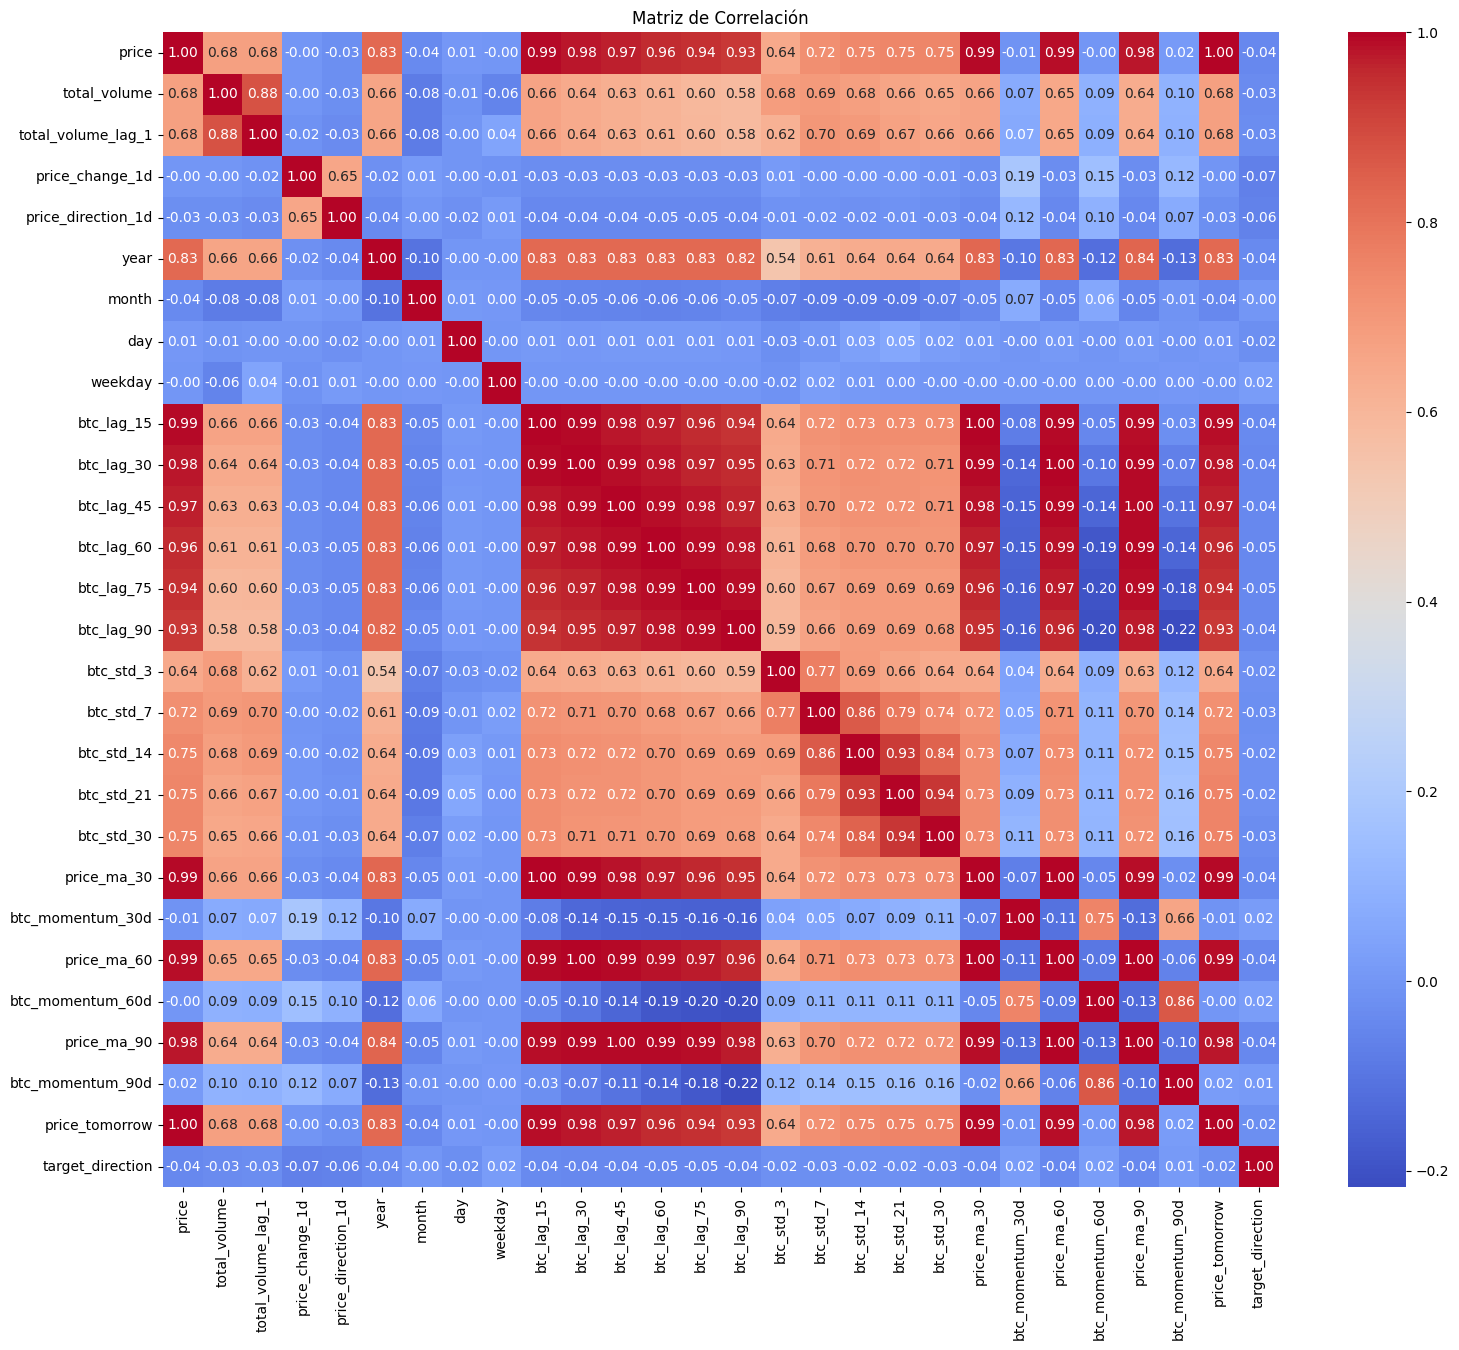

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

df_pd = df.to_pandas()
corr = df_pd.drop(columns=["date"]).corr()

plt.figure(figsize=(18, 15))  # Ajusta el tamaño según lo que necesites
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

In [8]:
carpeta_modelos = Path('models/')
nombre_archivo_data_test = 'xgBoost_btc_parametros_direccional.parquet'
nombre_archivo_data_real = 'xgBoost_btc_parametros_direccional_data_2025.parquet'

n_estimators = [200, 300, 400]
max_depth = [2, 3, 4]
learning_rates = [0.1, 0.2]
subsamples = [0.8, 0.9]
colsamples_bytree = [0.8, 0.9]

# Calcular total de combinaciones
total_combinaciones = len(n_estimators) * len(max_depth) * len(learning_rates) * len(subsamples) * len(colsamples_bytree)

print(f"Probando {total_combinaciones} combinaciones...")

data_test = []
data_real_2025 = []
modelos = []
combinaciones = list(itertools.product(n_estimators, max_depth, learning_rates, subsamples, colsamples_bytree))

iteracion = 0
for estimator, depth, lr, subsample, colsample in tqdm(combinaciones, desc="Entrenando modelos"):    
    datos_dict_test, datos_dict_real, modelo = entrena_evalua(
        estimators=estimator,
        depth=depth,
        learning_rate=lr,
        subsample=subsample,
        colsample=colsample,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        df_test=df_test,
        X_test_future=X_test_future,
        y_test_future=y_test_future,
        df_future=df_future,
        iteracion=iteracion
    )
    data_test.append(datos_dict_test)
    data_real_2025.append(datos_dict_real)
    modelos.append(modelo)
    iteracion += 1

Probando 72 combinaciones...


Entrenando modelos:   0%|          | 0/72 [00:00<?, ?it/s]

In [9]:
df_parametros_data_test = pl.DataFrame(data_test)
df_parametros_data_2025 = pl.DataFrame(data_real_2025)


#### Seleccionando Mejores Parámetros con data 2025

In [10]:
df_parametros_data_2025.sort("directional_accuracy", descending=True).head(1)

directional_accuracy,sharpe_ratio,cumulative_return,Compound_Annual_Growth_Rate,n_evaluated_days,estimators,depth,learning_rate,subsample,colsample_bytree,iteracion
f64,f64,f64,f64,i64,i64,i64,f64,f64,f64,i64
0.558394,NaN,NaN,NaN,274,300,4,0.2,0.8,0.8,44


In [ ]:
'''
directional_accuracy   0.536496   con [price, total_volume, stock_index_sp500, price_gold, rate_US10Y, stock_index_ni225, stock_index_dowjones]

directional_accuracy   0.540146   con [price, total_volume, stock_index_sp500, price_gold, rate_US10Y, stock_index_ni225]

directional_accuracy   0.523809   con [price, total_volume, stock_index_sp500, rate_US10Y]

directional_accuracy   0.511029   con [price, total_volume, stock_index_sp500, price_gold]

directional_accuracy   0.540441   con [price, total_volume, stock_index_sp500]     **

directional_accuracy   0.558394   con [price, total_volume, rate_US10Y]

directional_accuracy   0.558394   con [price, total_volume]

directional_accuracy   0.527472   con [price]

'''

### Recuperando el Modelo con el mejor `directional_accuracy`

In [12]:
parametros_data_2025 = df_parametros_data_2025.sort("directional_accuracy", descending=True).head(1).to_dicts()[0]
modelo_comprobacion = modelos[parametros_data_2025['iteracion']]

In [ ]:
import copy

def comprobacion(model):
    # Modelo tal cual sera utilizado en Produccion
    xgboost_model = model
 
    X_input_xgboost = X_test_future
    
    # Inferencia 
    preds = xgboost_model.predict(X_input_xgboost)
    y_test = copy.deepcopy(y_test_future)

    aciertos_direccion = 0
    for i in range(len(preds)):
        if (preds[i] > 0 and y_test[i] > 0) or (preds[i] < 0 and y_test[i] < 0):
            aciertos_direccion += 1

    directional_accuracy = aciertos_direccion / len(preds)
    return directional_accuracy

directional_accuracy = comprobacion(modelo_comprobacion)
print(f"directional_accuracy --> {directional_accuracy}")

directional_accuracy --> 0.5583941605839416


***
***
### 💾 Guardando los Modelos

In [ ]:
# import joblib

# joblib.dump(modelo_comprobacion, 'models/xgboost_model_data_2025.pkl')


['models/xgboost_model_data_2025.pkl']